Read/Tidy results from PCA-SIFT Training

In [1]:
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}
LABELS = [CATS_NAMES[id] for id in sorted(list(TOP_10_CATS_ID))]

In [3]:
tdy = datetime(2025, 4, 26, 4, 37, 48)
top_model_dir = Path(f'models_coco/PCA-SIFT/{tdy.strftime("%Y%m%d-%H%M%S")}/')

if not top_model_dir.exists():
    raise FileNotFoundError(f"Directory {top_model_dir} does not exist.")

In [4]:
# go through all directories in the top_model_dir to build the hyperparameter grid for us
# assume there are KMeans and PCA N components as hyperparameters

def get_hyperparameter_grid(top_model_dir):
    hyperparameter_grid = []
    for model_dir in top_model_dir.iterdir():
        if not model_dir.is_dir():
            continue
        # get the KMeans n_clusters
        kmeans_n_clusters = int(model_dir.name.split('_')[1])
        # get the PCA N components
        pca_n_components = int(model_dir.name.split('_')[3])
        # add to the hyperparameter grid
        hyperparameter_grid.append((kmeans_n_clusters, pca_n_components))
    return hyperparameter_grid

hyperparameter_grid = sorted(get_hyperparameter_grid(top_model_dir))
hyperparameter_grid

[(20, 20),
 (20, 50),
 (20, 128),
 (40, 20),
 (40, 50),
 (40, 128),
 (80, 20),
 (80, 50),
 (80, 128),
 (160, 20),
 (160, 50),
 (160, 128),
 (320, 20),
 (320, 50),
 (320, 128),
 (640, 20),
 (640, 50),
 (640, 128)]

In [5]:
# create a dataframe to store the results
# we are interested in weighted acc of all models in test and evaluation sets
# and weighted F1 score on both sets

df_testset_dict = {'kmeans_n_clusters':[], 'pca_n_components':[], 'weighted_acc':[], 'weighted_f1':[]}
df_evalset_dict = {'kmeans_n_clusters': [], 'pca_n_components': [], 'weighted_acc':[], 'weighted_f1':[]}

In [19]:
# we loop through the hyperparameter grid
# visit the directory
# grab the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
# and load them
# then we calculate the weighted acc and f1 score

import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score

def calculate_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    weighted_acc = balanced_accuracy_score(y_true, y_pred)
    weighted_f1 = report['weighted avg']['f1-score']
    return acc, weighted_acc, weighted_f1

for kmeans_n_clusters, pca_n_components in hyperparameter_grid:
    # visit the directory
    model_dir = top_model_dir / f'KMeans_{kmeans_n_clusters}_PCA_{pca_n_components}'
    if not model_dir.exists():
        continue
    # load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
    y_test = np.load(model_dir / f'y_test_filtered.npy')
    y_pred_test = np.load(model_dir / f'y_pred_test.npy')
    y_eval = np.load(model_dir / f'y_val_filtered.npy')
    y_pred_eval = np.load(model_dir / f'y_pred_val.npy')

    # calculate the metrics
    acc_test, weighted_acc_test, weighted_f1_test = calculate_metrics(y_test, y_pred_test)
    acc_eval, weighted_acc_eval, weighted_f1_eval = calculate_metrics(y_eval, y_pred_eval)

    print('---' * 20)
    print(f'KMeans n_clusters: {kmeans_n_clusters}, PCA n_components: {pca_n_components}')
    print(f'Weighted Acc Test: {weighted_acc_test}, Weighted F1 Test: {weighted_f1_test}')
    print(f'Weighted Acc Eval: {weighted_acc_eval}, Weighted F1 Eval: {weighted_f1_eval}')
    print('---' * 20)

    # add to the dictionaries
    df_testset_dict['kmeans_n_clusters'].append(kmeans_n_clusters)
    df_testset_dict['pca_n_components'].append(pca_n_components)
    df_testset_dict['weighted_acc'].append(weighted_acc_test)
    df_testset_dict['weighted_f1'].append(weighted_f1_test)

    df_evalset_dict['kmeans_n_clusters'].append(kmeans_n_clusters)
    df_evalset_dict['pca_n_components'].append(pca_n_components)
    df_evalset_dict['weighted_acc'].append(weighted_acc_eval)
    df_evalset_dict['weighted_f1'].append(weighted_f1_eval)

# create the dataframes
df_testset = pd.DataFrame(df_testset_dict)
df_evalset = pd.DataFrame(df_evalset_dict)


------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 20
Weighted Acc Test: 0.10054514066260072, Weighted F1 Test: 0.15449823375394992
Weighted Acc Eval: 0.10072167347081185, Weighted F1 Eval: 0.3982481790704953
------------------------------------------------------------
------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 50
Weighted Acc Test: 0.09993577895245033, Weighted F1 Test: 0.15315783470366576
Weighted Acc Eval: 0.10195255976005599, Weighted F1 Eval: 0.3984948121322515
------------------------------------------------------------
------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 128
Weighted Acc Test: 0.10012981310749274, Weighted F1 Test: 0.15370188638756474
Weighted Acc Eval: 0.10174544516234689, Weighted F1 Eval: 0.4000037679408856
------------------------------------------------------------
------------------------------------

In [20]:
df_testset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
0,20,20,0.100545,0.154498
1,20,50,0.099936,0.153158
2,20,128,0.100130,0.153702
3,40,20,0.099151,0.155356
4,40,50,0.100126,0.156689
5,40,128,0.100230,0.156930
6,80,20,0.099788,0.158234
7,80,50,0.100009,0.158014
8,80,128,0.099941,0.157431
9,160,20,0.098646,0.154480


In [21]:
df_evalset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
0,20,20,0.100722,0.398248
1,20,50,0.101953,0.398495
2,20,128,0.101745,0.400004
3,40,20,0.102838,0.399469
4,40,50,0.101499,0.398351
5,40,128,0.101718,0.399150
6,80,20,0.099621,0.394476
7,80,50,0.099992,0.395059
8,80,128,0.100140,0.395211
9,160,20,0.099769,0.395020


In [22]:
# sort the dataframes by weighted f1 score
df_testset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
29,160,128,0.100868,0.158874
11,160,128,0.100868,0.158874
6,80,20,0.099788,0.158234
24,80,20,0.099788,0.158234
12,320,20,0.100203,0.158131
30,320,20,0.100203,0.158131
25,80,50,0.100009,0.158014
7,80,50,0.100009,0.158014
16,640,50,0.100333,0.157839
34,640,50,0.100333,0.157839


In [23]:
df_evalset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
2,20,128,0.101745,0.400004
20,20,128,0.101745,0.400004
21,40,20,0.102838,0.399469
3,40,20,0.102838,0.399469
5,40,128,0.101718,0.399150
23,40,128,0.101718,0.399150
19,20,50,0.101953,0.398495
1,20,50,0.101953,0.398495
4,40,50,0.101499,0.398351
22,40,50,0.101499,0.398351


In [24]:
np.log(np.array(df_testset['kmeans_n_clusters'].unique(), dtype=int))

array([2.99573227, 3.68887945, 4.38202663, 5.07517382, 5.768321  ,
       6.46146818])

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the results as multi-line plots

def plot_results(df, title, x, y, x_label, y_label):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x, y=y, hue='pca_n_components', marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # apply log scale to the x axis
    plt.xscale('log', base=2)
    plt.xticks(df['kmeans_n_clusters'].unique(), labels=df['kmeans_n_clusters'].unique())
    plt.legend(title='PCA n_components')
    plt.grid()
    plt.show()

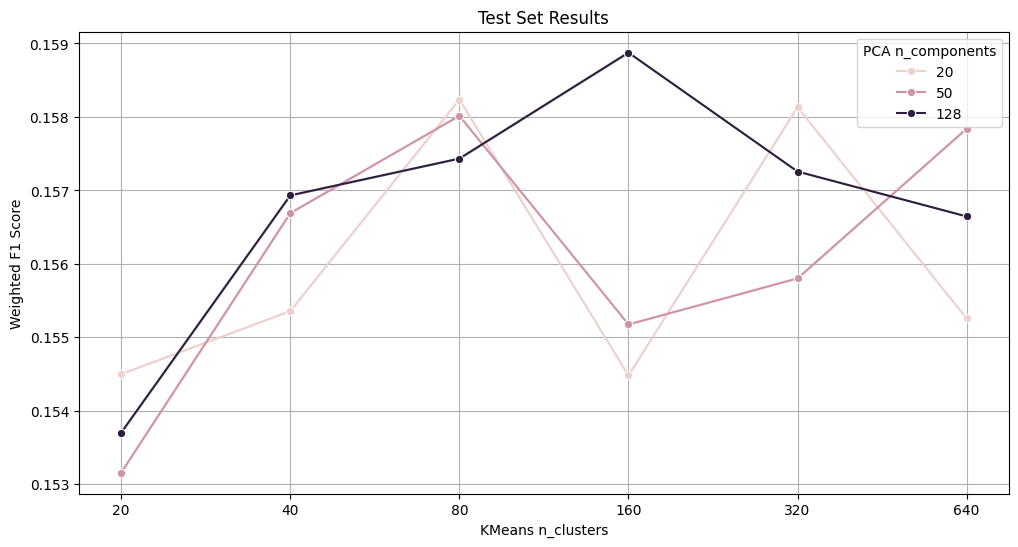

In [26]:
plot_results(df_testset, 'Test Set Results', 'kmeans_n_clusters', 'weighted_f1', 'KMeans n_clusters', 'Weighted F1 Score')

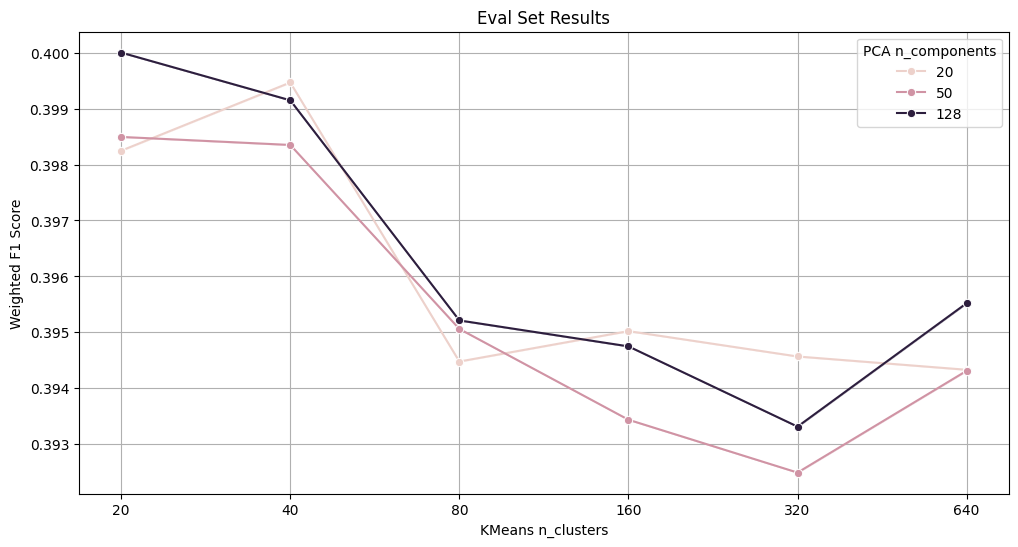

In [27]:
plot_results(df_evalset, 'Eval Set Results', 'kmeans_n_clusters', 'weighted_f1', 'KMeans n_clusters', 'Weighted F1 Score')

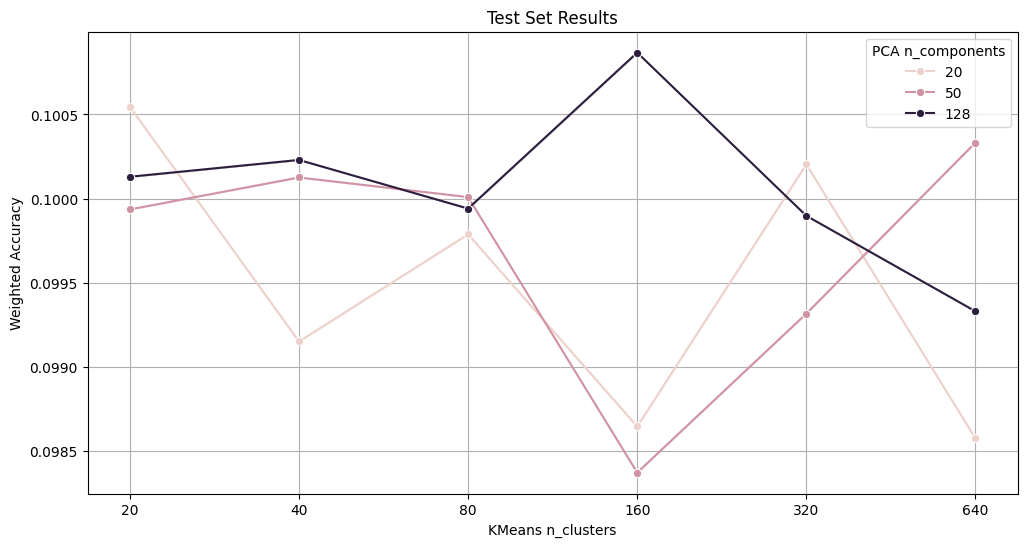

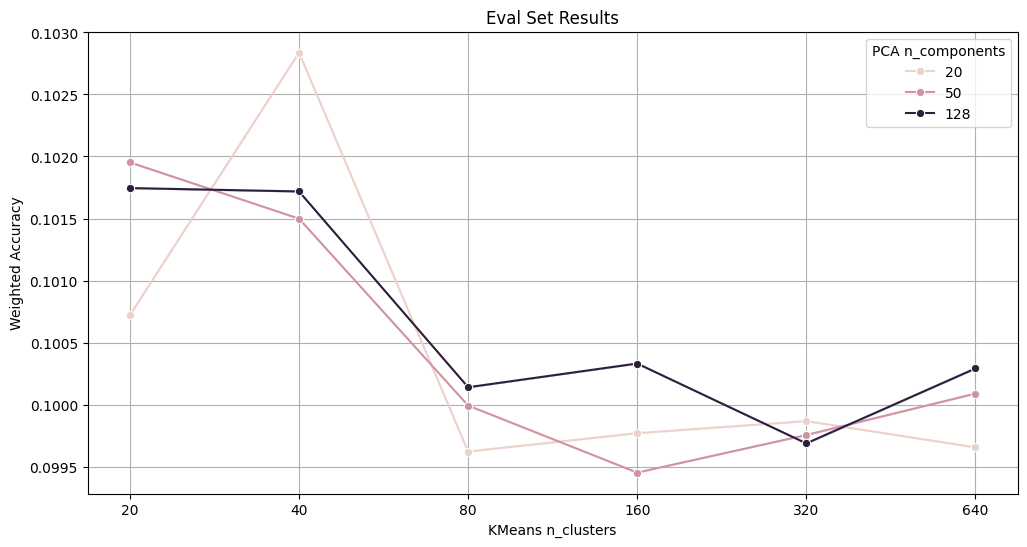

In [28]:
plot_results(df_testset, 'Test Set Results', 'kmeans_n_clusters', 'weighted_acc', 'KMeans n_clusters', 'Weighted Accuracy')
plot_results(df_evalset, 'Eval Set Results', 'kmeans_n_clusters', 'weighted_acc', 'KMeans n_clusters', 'Weighted Accuracy')

Select the best model and view its confusion matrix

In [29]:
best_model_eval = df_evalset.loc[df_evalset['weighted_f1'].idxmax()]
best_kmeans_n_clusters, best_pca_n_components = int(best_model_eval['kmeans_n_clusters']), int(best_model_eval['pca_n_components'])

model_dir = top_model_dir / f'KMeans_{best_kmeans_n_clusters}_PCA_{best_pca_n_components}'
if not model_dir.exists():
    raise FileNotFoundError(f"Directory {model_dir} does not exist.")

# load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
y_test = np.load(model_dir / f'y_test_filtered.npy')
y_pred_test = np.load(model_dir / f'y_pred_test.npy')
y_eval = np.load(model_dir / f'y_val_filtered.npy')
y_pred_eval = np.load(model_dir / f'y_pred_val.npy')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Assuming you have a list of class names

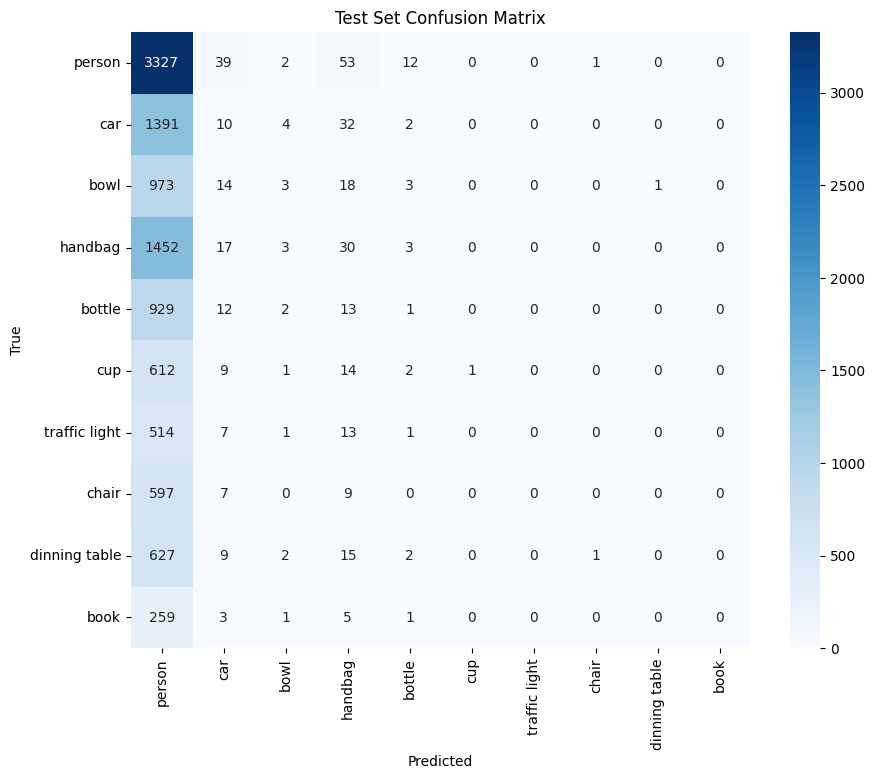

In [30]:
plot_confusion_matrix(y_test, y_pred_test, LABELS, 'Test Set Confusion Matrix')

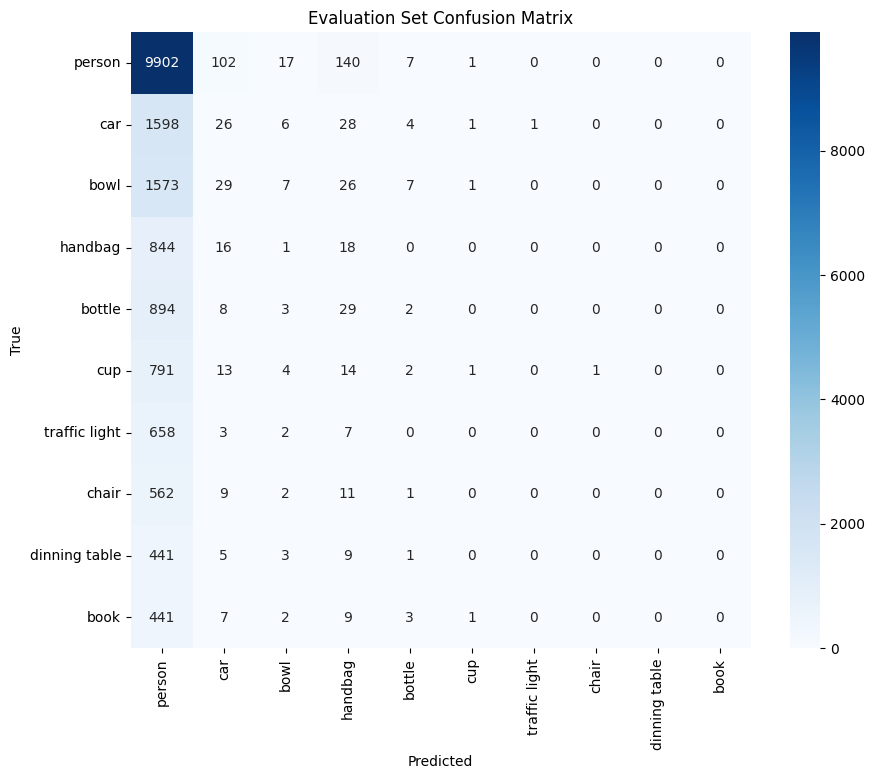

In [31]:
plot_confusion_matrix(y_eval, y_pred_eval, LABELS, 'Evaluation Set Confusion Matrix')